In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
plt.rcParams["figure.figsize"] = (10, 10)

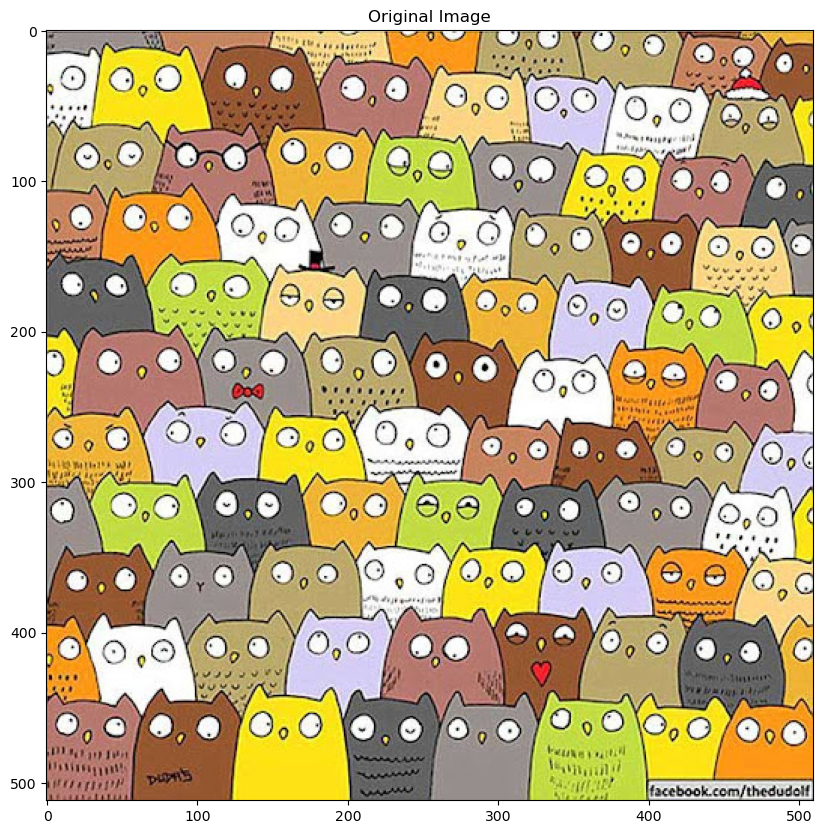

In [3]:
img = cv2.imread("cat.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.show()

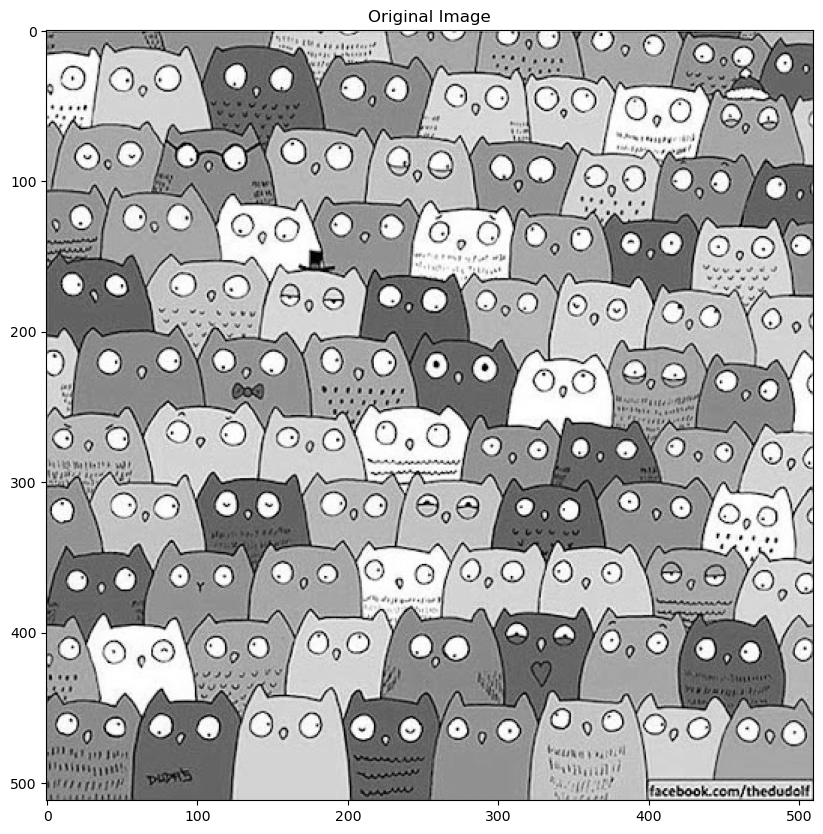

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")
plt.title("Original Image")
plt.show()

In [5]:
cv2.imwrite("gray.jpg",gray)

True

In [6]:
histogram = cv2.calcHist([gray], [0], None, [256], [0, 256])

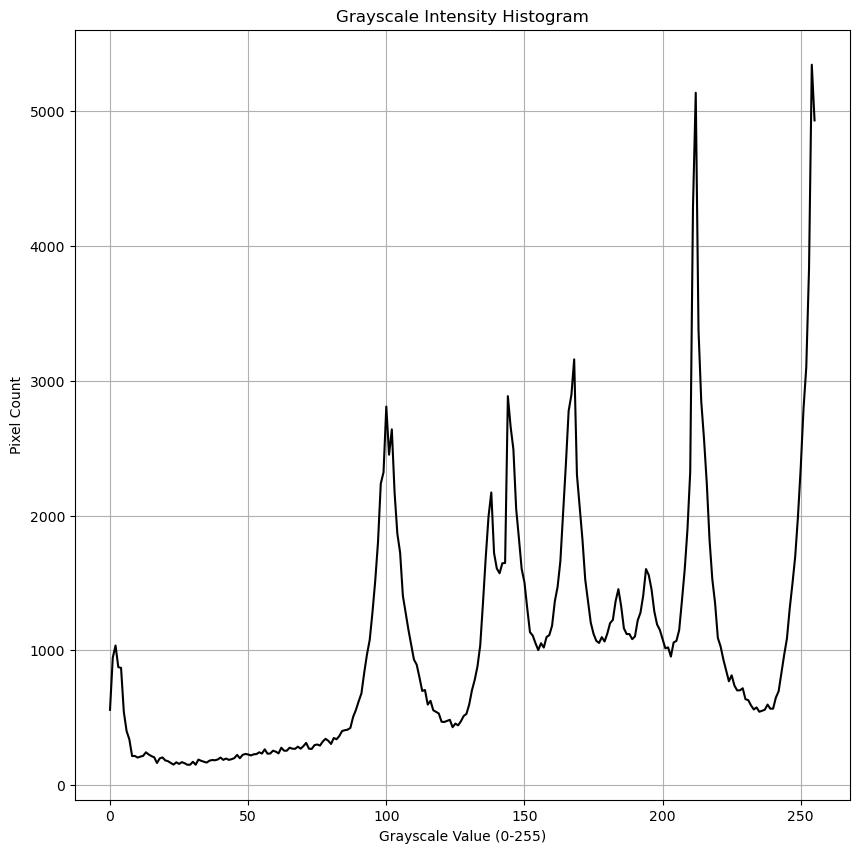

In [7]:
plt.plot(histogram, color='black')
plt.title("Grayscale Intensity Histogram")
plt.xlabel("Grayscale Value (0-255)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.savefig("histogram.png", dpi=300, bbox_inches="tight")  # Save the plot
plt.show()

In [8]:
h, w = gray.shape
x, y = 10, 10

In [9]:
if x >= 3 and x < w - 3 and y >= 3 and y < h - 3:
    patch = gray[y-3:y+4, x-3:x+4]

In [10]:
patch

array([[144, 144, 141, 147, 144, 141, 144],
       [135, 139, 145, 151, 151, 147, 150],
       [155, 143, 147, 150, 149, 150, 149],
       [157, 146, 145, 142, 142, 148, 149],
       [144, 140, 153, 144, 135, 148, 149],
       [149, 145, 160, 156, 153, 174, 168],
       [167, 168, 168, 158, 141, 127, 143]], dtype=uint8)

In [11]:
def quantize_gray_image(gray, k):
    img_data = gray.reshape((-1, 1))
    img_data = np.float32(img_data)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(img_data, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    centers = np.uint8(centers)
    quantized_gray = centers[labels.flatten()] 
    quantized_gray = quantized_gray.reshape(gray.shape)
    
    return quantized_gray


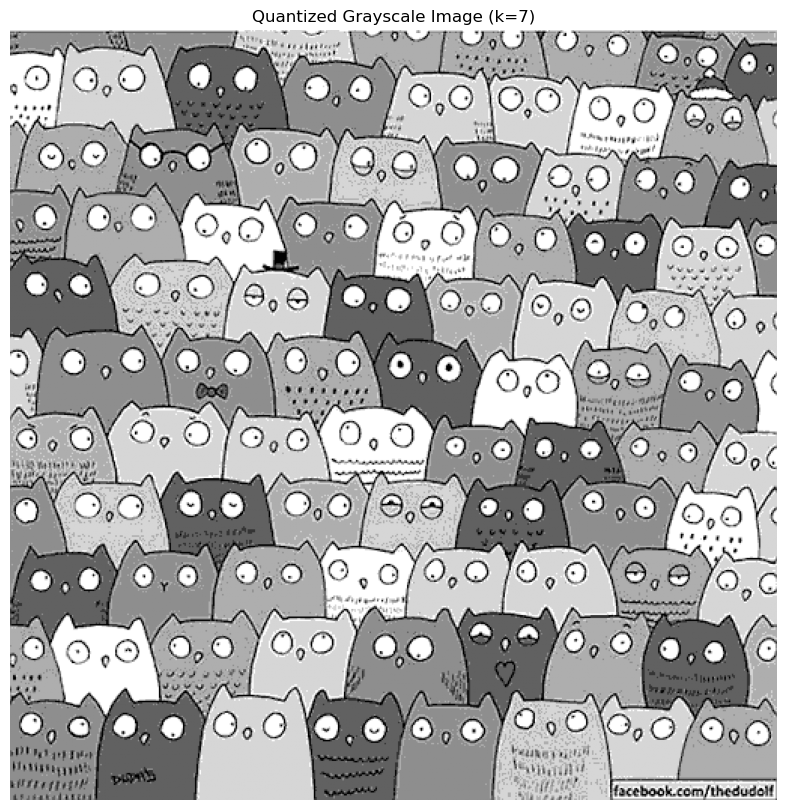

In [12]:
k = 7
quantized_gray = quantize_gray_image(gray, k)

plt.imshow(quantized_gray, cmap="gray")
plt.title(f"Quantized Grayscale Image (k={k})")
plt.axis("off")
plt.show()

In [13]:
histogram = cv2.calcHist([quantized_gray], [0], None, [256], [0, 256])

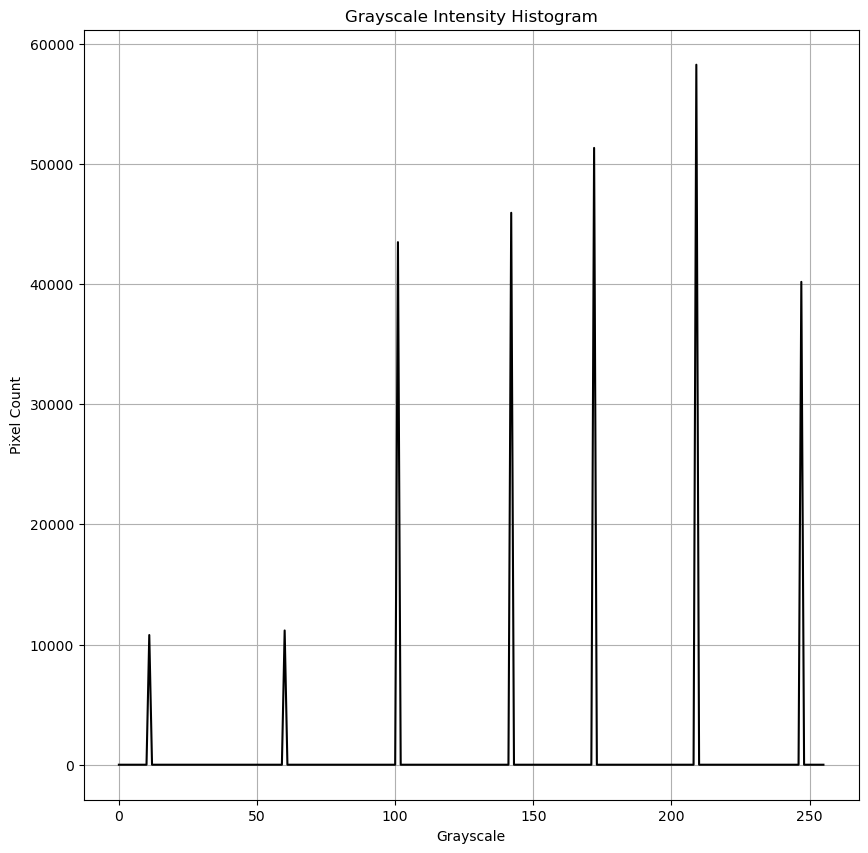

In [14]:
plt.plot(histogram, color='black')
plt.title("Grayscale Intensity Histogram")
plt.xlabel("Grayscale")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.savefig("quantized_histogram.png", dpi=300, bbox_inches="tight") 
plt.show()

In [15]:
if x >= 3 and x < w - 3 and y >= 3 and y < h - 3:
    patch = quantized_gray[y-3:y+4, x-3:x+4]

In [16]:
patch

array([[142, 142, 142, 142, 142, 142, 142],
       [142, 142, 142, 142, 142, 142, 142],
       [142, 142, 142, 142, 142, 142, 142],
       [142, 142, 142, 142, 142, 142, 142],
       [142, 142, 142, 142, 142, 142, 142],
       [142, 142, 172, 142, 142, 172, 172],
       [172, 172, 172, 172, 142, 142, 142]], dtype=uint8)

In [17]:
def count_owls_per_gray_level(quantized_gray, min_size=500):
    unique_values = np.unique(quantized_gray)
    owl_counts = {}

    for value in unique_values:
        mask = (quantized_gray == value).astype(np.uint8)

        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

        owl_count = sum(1 for stat in stats[1:] if stat[4] >= min_size)
        owl_counts[value] = owl_count

    return owl_counts

In [18]:
owl_counts = count_owls_per_gray_level(quantized_gray, min_size=300)

for gray_value, count in owl_counts.items():
    print(f"Level {gray_value}: {count}")

total_owls = sum(owl_counts.values())
print(f"Total: {total_owls}")

Level 11: 0
Level 60: 0
Level 101: 15
Level 142: 21
Level 172: 21
Level 209: 28
Level 247: 10
Total: 95


In [ ]:
def draw_and_crop_bounding_boxes(quantized_gray, output_folder="owls", min_size=500):
    os.makedirs(output_folder, exist_ok=True)
    unique_values = np.unique(quantized_gray)
    img_color = cv2.cvtColor(quantized_gray, cv2.COLOR_GRAY2BGR)
    count = 0
    for value in unique_values:
        mask = (quantized_gray == value).astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        for i in range(1, num_labels):
            x, y, w, h, area = stats[i]
            if area >= min_size: 
                cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box
                # Crop the object
                cropped = quantized_gray[y:y+h, x:x+w]
                # Save the cropped image
                filename = os.path.join(output_folder, f"object_{count}.jpg")
                cv2.imwrite(filename, cropped)
                count += 1
    return img_color

In [ ]:
processed_image = draw_and_crop_bounding_boxes(quantized_gray, min_size=300)
cv2.imwrite("output_with_boxes.png", processed_image)

True

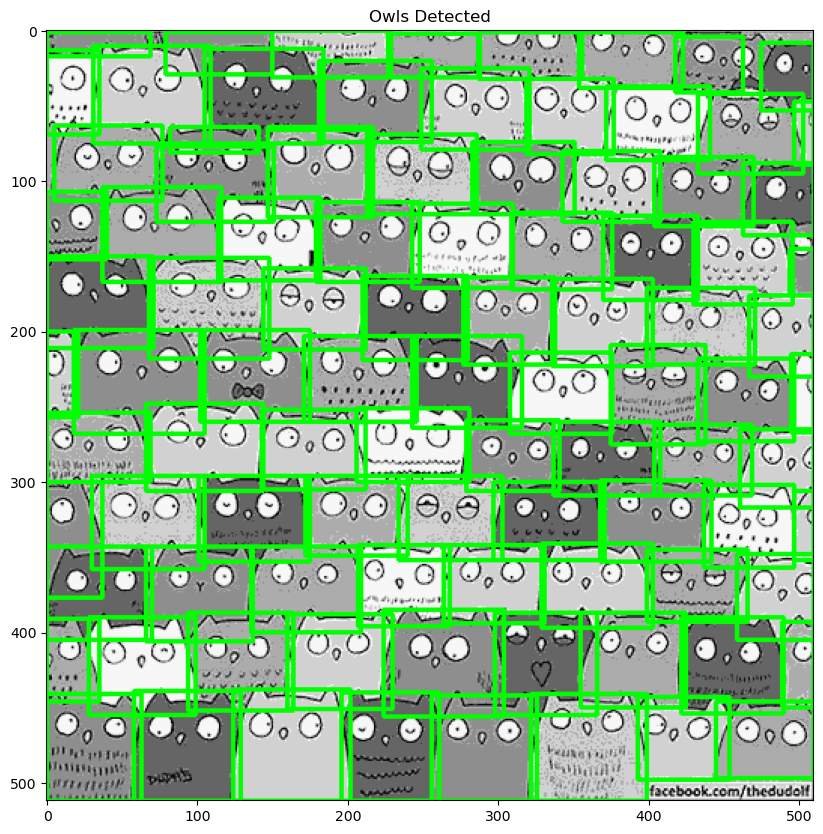

In [21]:
img = cv2.imread("output_with_boxes.png")
plt.imshow(img)
plt.title("Owls Detected")
plt.savefig("detect.png", dpi=300, bbox_inches="tight") 
plt.show()

# Template Matching on the owl beaks

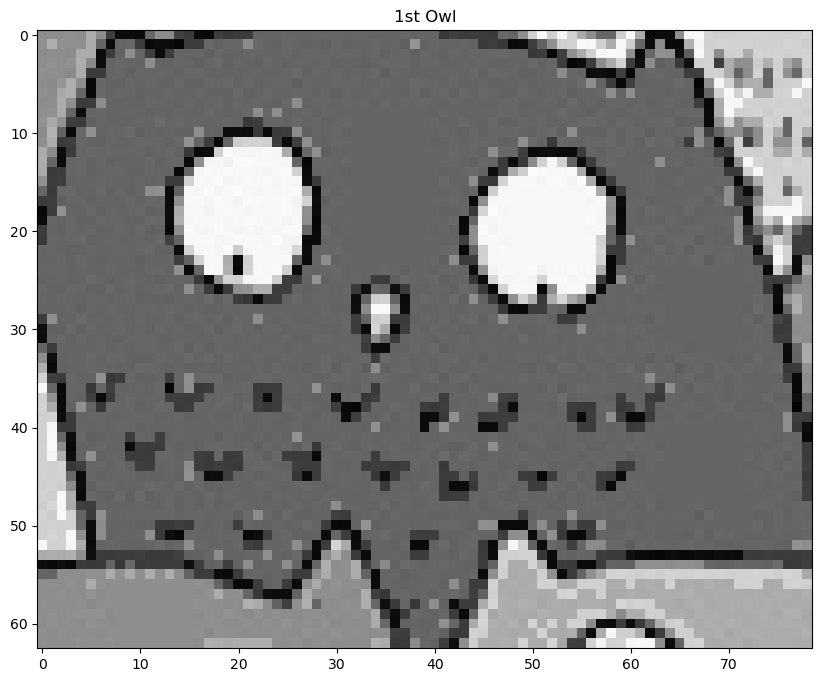

In [37]:
img = cv2.imread('owls/object_1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("1st Owl")
plt.savefig("1st Owl.png", dpi=300, bbox_inches="tight") 
plt.show()

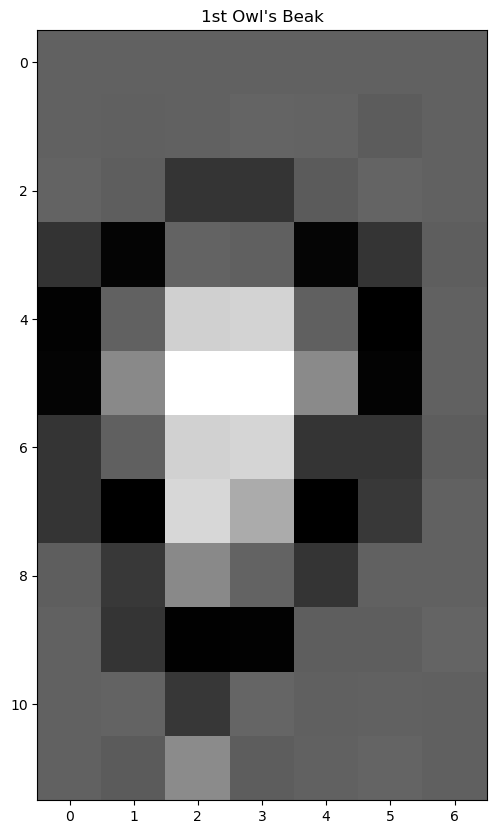

In [39]:
#crop image
crop = img[23:35, 32:39]
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
plt.title("1st Owl's Beak")
plt.imshow(crop, cmap="gray")
plt.savefig("1st Owl's Beak.png", dpi=300, bbox_inches="tight") 
plt.show()

In [ ]:
unmatched_images = []
for i in range(total_owls):
    img_path = f'owls/object_{i}.jpg'
    img_test = cv2.imread(img_path)

    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

    height, width = img_test.shape

    result = cv2.matchTemplate(img_test, crop, cv2.TM_CCOEFF_NORMED)
    threshold = 0.55
    locations = np.where(result >= threshold)

    if len(locations[0]) == 0 and width > 40 and height > 40:
        unmatched_images.append(img_path)

for img_path in unmatched_images:
    print(img_path)
    
print(len(unmatched_images))


owls/object_32.jpg
owls/object_39.jpg
owls/object_40.jpg
owls/object_44.jpg
owls/object_48.jpg
owls/object_50.jpg
owls/object_51.jpg
owls/object_58.jpg
owls/object_60.jpg
owls/object_64.jpg
owls/object_65.jpg
owls/object_69.jpg
owls/object_72.jpg
owls/object_73.jpg
owls/object_74.jpg
owls/object_75.jpg
owls/object_79.jpg
owls/object_80.jpg
owls/object_84.jpg
owls/object_86.jpg
owls/object_87.jpg
owls/object_88.jpg
owls/object_89.jpg
owls/object_91.jpg
owls/object_92.jpg
owls/object_93.jpg
owls/object_94.jpg
27


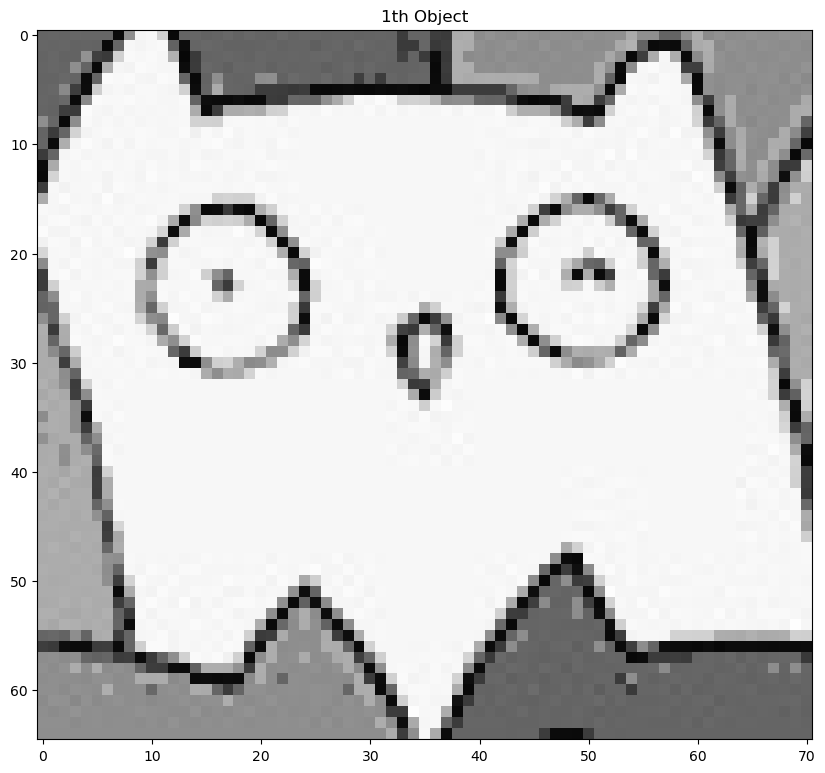

In [25]:
img = cv2.imread(unmatched_images[-1])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("1th Object")
plt.show()

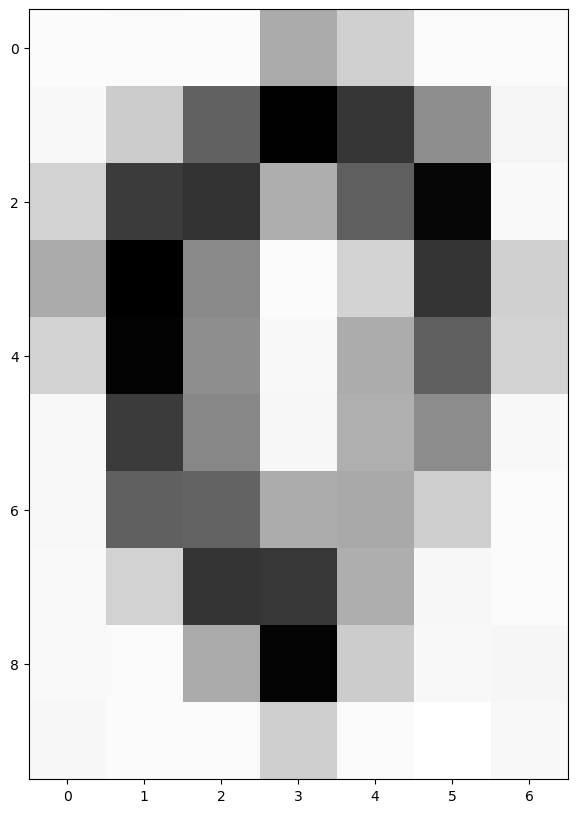

In [26]:
#crop image
crop = img[25:35, 32:39]
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
plt.imshow(crop, cmap="gray")

In [ ]:
unmatched_images2 = []
for img_path in unmatched_images:
    img_test = cv2.imread(img_path)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

    height, width = img_test.shape


    result = cv2.matchTemplate(img_test, crop, cv2.TM_CCOEFF_NORMED)
    threshold = 0.55
    locations = np.where(result >= threshold)

    if len(locations[0]) == 0 and width > 40 and height > 40:
        unmatched_images2.append(img_path)

for img_path in unmatched_images2:
    print(img_path)
    
print(len(unmatched_images2))

owls/object_32.jpg
1


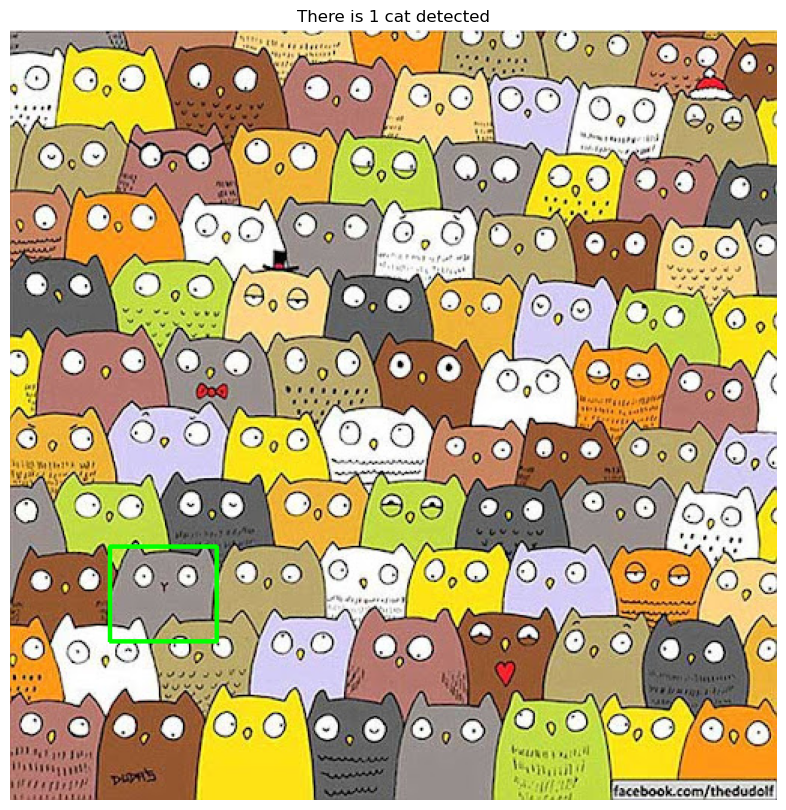

In [ ]:
img = cv2.imread("cat.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
object_img = cv2.imread('owls/object_32.jpg', cv2.IMREAD_GRAYSCALE)

result = cv2.matchTemplate(quantized_gray, object_img, cv2.TM_CCOEFF_NORMED)
threshold = 0.8
locations = np.where(result >= threshold)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w = object_img.shape

for pt in zip(*locations[::-1]): 
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

title = f'There is {len(unmatched_images2)} cat detected'

plt.imshow(img_rgb)
plt.title(title)
plt.axis('off')
plt.savefig("Cat Detected.png", dpi=300, bbox_inches="tight") 
plt.show()

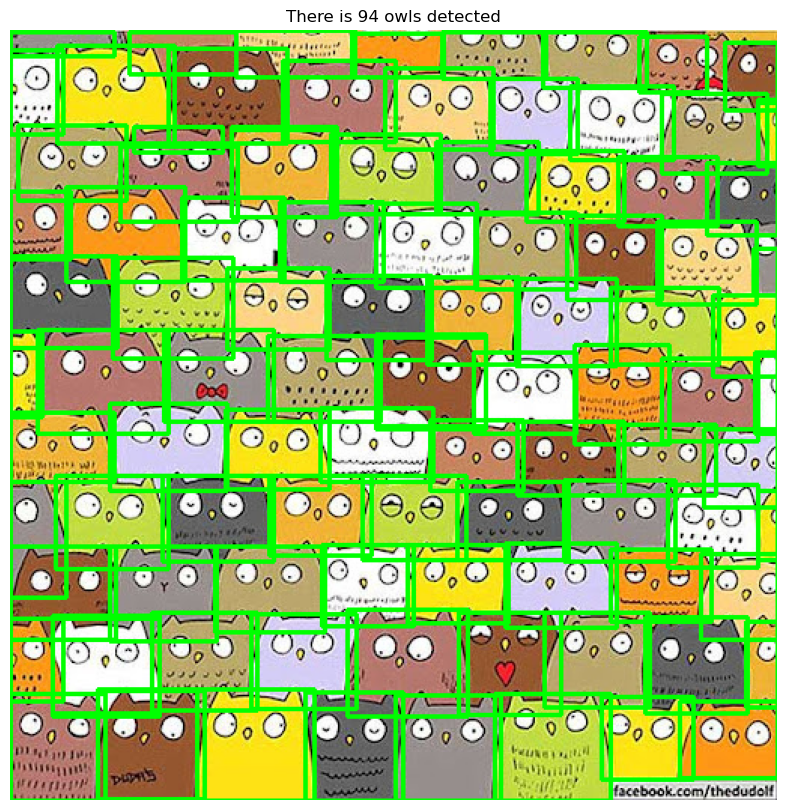

In [ ]:
owl_dir = 'owls/'
owl_files = [f for f in os.listdir(owl_dir) if f.endswith('.jpg') and f != 'object_32.jpg']

output_img = img_rgb.copy()

# Loop through each owl template (except object_32.jpg)
for owl_file in owl_files:
    object_path = os.path.join(owl_dir, owl_file)
    object_img = cv2.imread(object_path, cv2.IMREAD_GRAYSCALE)
    
    # Perform template matching
    result = cv2.matchTemplate(quantized_gray, object_img, cv2.TM_CCOEFF_NORMED)
    threshold = 0.8
    locations = np.where(result >= threshold)
    
    # Draw rectangles for each match
    h, w = object_img.shape
    for pt in zip(*locations[::-1]):
        cv2.rectangle(output_img, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

# Update title (assuming unmatched_images2 is defined elsewhere)
title = f'There is {total_owls - len(unmatched_images2)} owls detected'

# Display the result
plt.imshow(output_img)
plt.title(title)
plt.axis('off')
plt.savefig("Owl Detected.png", dpi=300, bbox_inches="tight") 
plt.show()